# Self-Driving Car Engineer Nanodegree


## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import glob
%matplotlib inline

## Camera Calibration
Extract object points and image points for camera calibration

In [2]:
class Camera_Calibration(object):
    def __init__(self, recal=False):
        self.mtx = None
        self.dist = None
        if recal:
            self.reset_calibration_matrices()
        else:
            self.restore_undistortion_matrices()
    
    def reset_calibration_matrices(self):
        self.calculate_calibration_matrices()
        self.save_undistortion_matrices()
    
    def calculate_calibration_matrices(self):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        # Make a list of calibration images
        images = glob.glob('camera_cal/calibration*.jpg')

        # Step through the list and search for chessboard corners
        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            img_size = (img.shape[1], img.shape[2])
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)

                # Draw and display the corners
                cv2.drawChessboardCorners(img, (9,6), corners, ret)
                write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
                cv2.imwrite(write_name, img)
                # cv2.imshow('img', img)
                # cv2.waitKey(500)
        # cv2.destroyAllWindows()
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)    
        
    def save_undistortion_matrices(self):
        dist_pickle = {}
        dist_pickle["mtx"] = self.mtx
        dist_pickle["dist"] = self.dist

        file_handler = open("camera_cal/wide_dist_pickle.p", "wb")
        pickle.dump(dist_pickle, file_handler)
        file_handler.close()

    # Read mtx and dist from pickle file
    def restore_undistortion_matrices(self):
        file_handler = open("camera_cal/wide_dist_pickle.p", "rb")
        object_file = pickle.load(file_handler)
        file_handler.close()
        self.mtx = object_file["mtx"]
        self.dist = object_file["dist"]

    # Undistort the image with matrices computed in the previous steps
    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

Text(0.5, 1.0, 'Undistorted Image')

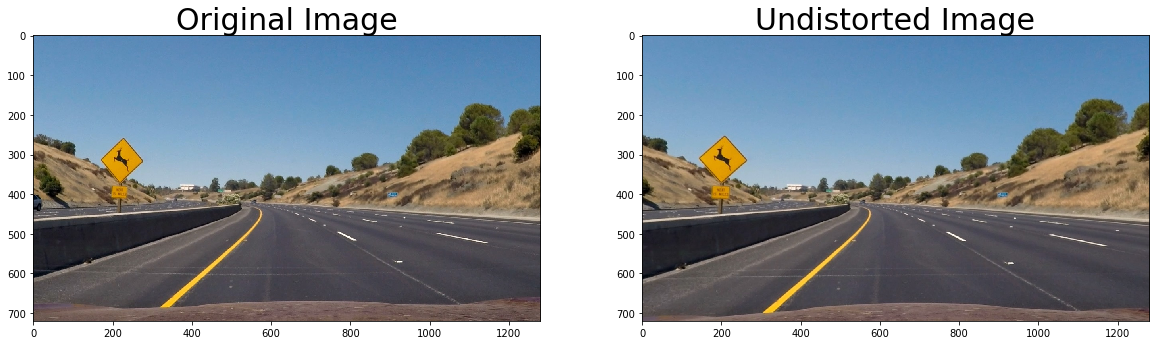

In [3]:
# Test undistortion on an image
cam_cal = Camera_Calibration()
cam_cal.calculate_calibration_matrices()

img = cv2.imread('test_images/test2.jpg')
dst = cam_cal.undistort(img)
cv2.imwrite('output_images/test_undist.jpg',dst)
 
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Thresholding for binary image
1. Transform the image to HLS space, in order to get more robust thresholding by taking avantage of the satuation difference between lane line and background (road). 
2. Use sobel operator focusing on x axis to detect the vertical lane line better.

In [4]:
class Binary_Thresholding(object):
    def __init__(self):
        self.sat_thresh = (160, 255)
        self.sobel_thresh = (20, 100)
        self.sdir_thresh = (0.7, 1.3)
        
    def binarize(self, img):
        # Convert the image to HLS color space and separte the channels
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        lum_channel, sat_channel = hls[:, :, 1], hls[:, :, 2]

        # Sobel operator
        sobel_x = cv2.Sobel(lum_channel, cv2.CV_64F, 1, 0)
        abs_sobel_x = np.absolute(sobel_x)
        scaled_sobel_x = np.uint8(255 * abs_sobel_x / np.max(abs_sobel_x))
        
        # Threshold x gradient
        binary_sobel_x = np.zeros_like(scaled_sobel_x)
        binary_sobel_x[(scaled_sobel_x >= self.sobel_thresh[0]) & (scaled_sobel_x <= self.sobel_thresh[1])] = 1
        
        sobel_y = cv2.Sobel(sat_channel, cv2.CV_64F, 0, 1)
        abs_sobel_y = np.absolute(sobel_y)
        
        direction_sobel = np.arctan2(abs_sobel_y, abs_sobel_x)
        scaled_sobel_dir = np.uint8(255 * direction_sobel / np.max(direction_sobel))
        
        # Threshold sobel direction
        binary_sobel_dir = np.zeros_like(scaled_sobel_dir)
        binary_sobel_dir[(scaled_sobel_dir >= self.sdir_thresh[0]) & (scaled_sobel_dir <= self.sdir_thresh[1])] = 1
        
        # Threshold color channel
        binary_sat = np.zeros_like(sat_channel)
        binary_sat[(sat_channel >= self.sat_thresh[0]) & (sat_channel <= self.sat_thresh[1])] = 1

        # Combine each channel
        binary_color = np.dstack((binary_sat, binary_sobel_x, np.zeros_like(binary_sobel_x))) * 255
        binary_result = np.zeros_like(binary_sat)
        binary_result[(binary_sat==1) | (binary_sobel_x==1) & (binary_sobel_dir==1)] = 255
        return binary_result

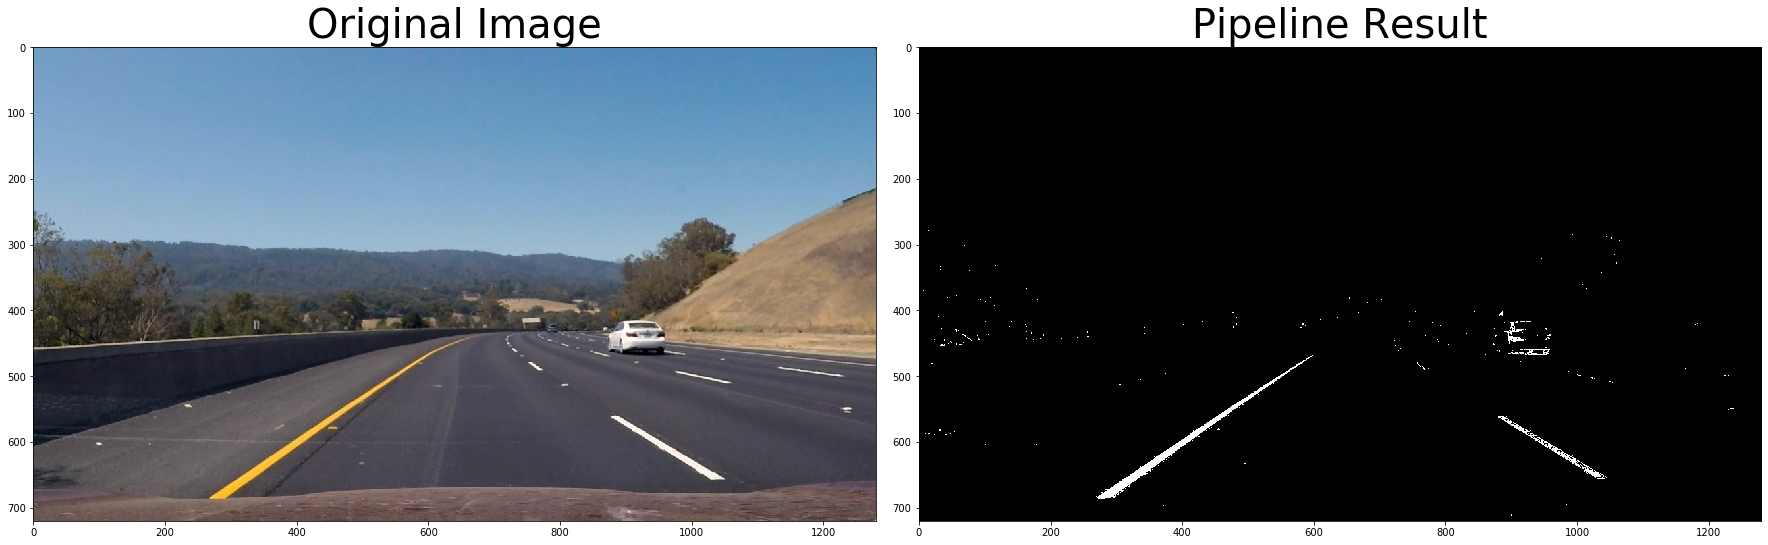

In [5]:
from os import listdir
from os.path import join

test_path = 'test_images/'
output_path = 'img_process/'
file_names = [f for f in listdir(test_path)]
bin_thresh = Binary_Thresholding()

for fname in file_names:
    img = mpimg.imread(join(test_path, fname))
    result = bin_thresh.binarize(img)
    # cv2.imwrite(join(output_path, fname), result)
    
# result = binarize(image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transformation

In [6]:
class Perspective_Transform(object):
    def __init__(self, shape=(720,1280)):
        self.width, self.height = shape[1], shape[0]
        self.offset = 200
        self.src = np.float32([[180, 720], [584, 455],
                               [706, 455], [1100, 720]])
        self.dst = np.float32([[self.offset, self.height], [self.offset, 0],
                               [self.width - self.offset, 0], [self.width - self.offset, self.height]])
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.Minv = cv2.getPerspectiveTransform(self.dst, self.src)
    
    def refresh_M(self, src, dst):
        self.src, self.dst = src, dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.Minv = cv2.getPerspectiveTransform(self.dst, self.src)

    def warp_perspective(self, img):
        return cv2.warpPerspective(img, self.M, (self.width, self.height), flags=cv2.INTER_LINEAR)
    
#     def draw_lines(self, img):
#         cv2.line(img, (190, 720), (584, 455), (255, 0, 0), 2)
#         cv2.line(img, (706, 455), (1120, 720), (255, 0, 0), )
#         cv2.line(img, (640, 0), (640, 720), (0, 255, 0), 5)


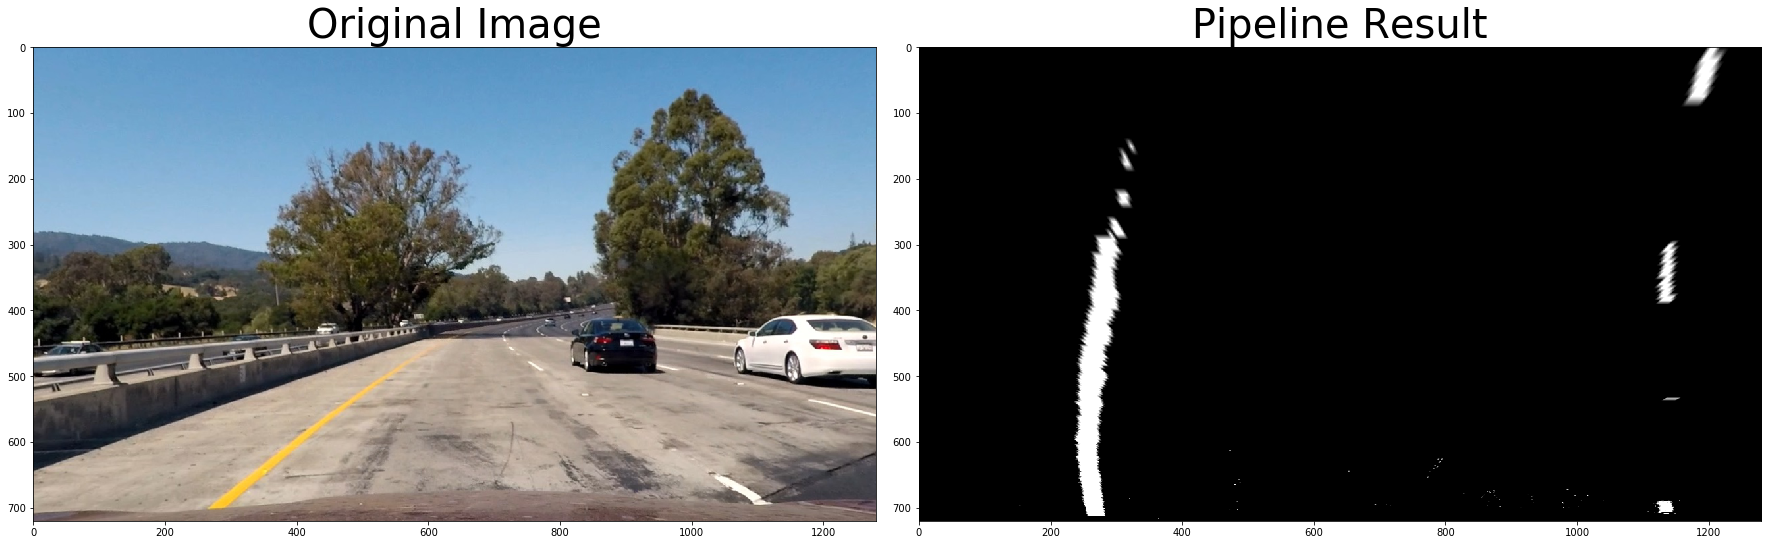

In [7]:
pers_trans = Perspective_Transform()
img = mpimg.imread('test_images/test1.jpg')
ud_img = cam_cal.undistort(img)
bin_img = bin_thresh.binarize(ud_img)
warped = pers_trans.warp_perspective(bin_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(ud_img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Lane Pixel Detection
1. Sliding window and fit polynomial
2. Use the previous poly-fit result

In [8]:
class Find_Pixel(object):
    def __init__(self, img_shape=(720,1280)):
        self.num_windows = 9
        self.margin = 80
        self.min_pix = 60
        self.img_width = img_shape[1]
        self.img_height = img_shape[0]
        self.mid_point = self.img_width // 2
        self.window_height = self.img_height // self.num_windows
        self.left_fit = None
        self.right_fit = None
        
    def nonzero(self, bin_img):
        nonzero = bin_img.nonzero()
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])
        return nonzero_x, nonzero_y
    
    def split_pixels(self, nonzero_x, nonzero_y, left_lane_inds, right_lane_inds):
        self.left_x = nonzero_x[left_lane_inds]
        self.left_y = nonzero_y[left_lane_inds]
        self.right_x = nonzero_x[right_lane_inds]
        self.right_y = nonzero_y[right_lane_inds]
        return self.left_x, self.left_y, self.right_x, self.right_y
        
    def find_pixel_sliding_window(self, binary_warped):
        histogram = np.sum(binary_warped, axis=0)
        left_x_base = np.argmax(histogram[:self.mid_point])
        right_x_base = np.argmax(histogram[self.mid_point:]) + self.mid_point

        nonzero_x, nonzero_y = self.nonzero(binary_warped)
        
        left_x_current, right_x_current = left_x_base, right_x_base
        left_lane_inds, right_lane_inds = [], []

        out_img = np.dstack((binary_warped, binary_warped, binary_warped))

        for window in range(self.num_windows):
            win_y_low = binary_warped.shape[0] - (window + 1) * self.window_height
            win_y_high = binary_warped.shape[0] - window * self.window_height
            win_x_left_low = left_x_current - self.margin
            win_x_left_high = left_x_current + self.margin
            win_x_right_low = right_x_current - self.margin
            win_x_right_high = right_x_current + self.margin

#             cv2.rectangle(out_img, (win_x_left_low, win_y_low),
#                           (win_x_left_high, win_y_high), (0, 255, 0), 2)
#             cv2.rectangle(out_img, (win_x_right_low, win_y_low),
#                           (win_x_right_high, win_y_high), (0, 255, 0), 2)
            good_left_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high)
                              & (nonzero_x >= win_x_left_low) & (nonzero_x < win_x_left_high)).nonzero()[0]
            good_right_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high)
                              & (nonzero_x >= win_x_right_low) & (nonzero_x < win_x_right_high)).nonzero()[0]
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > self.min_pix:
                left_x_current = np.int(np.mean(nonzero_x[good_left_inds]))
            if len(good_right_inds) > self.min_pix:
                right_x_current = np.int(np.mean(nonzero_x[good_right_inds]))

        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            pass

        left_x, left_y, right_x, right_y = self.split_pixels(nonzero_x, nonzero_y, left_lane_inds, right_lane_inds)

        return left_x, left_y, right_x, right_y

    def fit_poly(self, left_x, left_y, right_x, right_y):
        self.left_fit = np.polyfit(left_y, left_x, 2)
        self.right_fit = np.polyfit(right_y, right_x, 2)
        plot_y = np.linspace(0, self.img_height - 1, self.img_height)
        left_fit_x = self.left_fit[0] * plot_y ** 2 + self.left_fit[1] * plot_y + self.left_fit[2]
        right_fit_x = self.right_fit[0] * plot_y ** 2 + self.right_fit[1] * plot_y + self.right_fit[2]
        return left_fit_x, right_fit_x

#     def fit_poly_real(self, left_x, left_y, right_x, right_y):
#         left_fit_cr = np.polyfit(left_y * self.y_meter_per_pix, left_x * self.x_meter_per_pix, 2)
#         right_fit_cr = np.polyfit(right_y * self.y_meter_per_pix, right_x * self.x_meter_per_pix, 2)
#         return left_fit_cr, right_fit_cr
    
    def search_and_fit(self, binary_warped, left_fit=None, right_fit=None, should_visualize=False):
        if left_fit is None or right_fit is None:
            if self.left_fit is None or self.right_fit is None:
                # Initiate the poly by sliding window if not provided
                left_x, left_y, right_x, right_y = self.find_pixel_sliding_window(binary_warped)
                left_fit_x, right_fit_x = self.fit_poly(left_x, left_y, right_x, right_y)
        else:
            self.left_fit, self.right_fit = left_fit, right_fit
        
        nonzero_x, nonzero_y = self.nonzero(binary_warped)
        
        left_lane_inds = [(nonzero_x > (self.left_fit[0] * nonzero_y ** 2 + self.left_fit[1] * nonzero_y + self.left_fit[2] - self.margin))
                          & (nonzero_x < (self.left_fit[0] * nonzero_y ** 2 + self.left_fit[1] * nonzero_y + self.left_fit[2] + self.margin))]
        right_lane_inds = [(nonzero_x > (self.right_fit[0] * nonzero_y ** 2 + self.right_fit[1] * nonzero_y + self.right_fit[2] - self.margin))
                           & (nonzero_x < (self.right_fit[0] * nonzero_y ** 2 + self.right_fit[1] * nonzero_y + self.right_fit[2] + self.margin))]
        left_x, left_y, right_x, right_y = self.split_pixels(nonzero_x, nonzero_y, left_lane_inds, right_lane_inds)
        left_fit_x, right_fit_x = self.fit_poly(left_x, left_y, right_x, right_y)
        
#         if should_visualize:
#             out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
#             window_img = np.zeros_like(out_img)
#             out_img[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
#             out_img[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

#             # Generate a polygon to illustrate the search window area
#             # And recast the x and y points into usable format for cv2.fillPoly()
#             left_line_window1 = np.array([np.transpose(np.vstack([left_fit_x - self.margin, plot_y]))])
#             left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fit_x + self.margin, 
#                                       plot_y])))])
#             left_line_pts = np.hstack((left_line_window1, left_line_window2))
#             right_line_window1 = np.array([np.transpose(np.vstack([right_fit_x - self.margin, plot_y]))])
#             right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fit_x + self.margin, 
#                                       plot_y])))])
#             right_line_pts = np.hstack((right_line_window1, right_line_window2))

#             # Draw the lane onto the warped blank image
#             cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#             cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#             result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

#             # Plot the polynomial lines onto the image
#             # plt.plot(left_fit_x, plot_y, color='yellow')
#             # plt.plot(right_fit_x, plot_y, color='yellow')
#             return result

    def get_pixels(self):
        return (self.left_x, self.left_y, self.right_x, self.right_y)

In [9]:
find_pixel = Find_Pixel()
result = find_pixel.search_and_fit(warped)

/home/allenhsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/allenhsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/allenhsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will resul

## Calculate the Curvature


In [10]:
class Curvature_Measurement(object):
    def __init__(self, shape=(720, 1280)):
        self.y_meter_per_pix = 30 / 720
        self.x_meter_per_pix = 3.7 / 800
        self.img_height = shape[0]
        self.img_width = shape[1]
        
    def fit_poly_real(self, x, y):
        fit_cr = np.polyfit(y * self.y_meter_per_pix, x * self.x_meter_per_pix, 2)
        return fit_cr

    def get_curvature(self, line):
        points = line.generate_points()
        x, y = points[:,0], points[:,1]
        fit_cr = self.fit_poly_real(x, y)
        y_eval = np.max(y)
        curve_rad = ((1 + (2*fit_cr[0]*y_eval*self.y_meter_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        return curve_rad


## Identify the line class

In [11]:
from collections import deque
# Define a class to receive the characteristics of each line detection
class Line(object):
    def __init__(self, shape=(720,1280)):
        self.img_height = shape[0]
        self.img_width = shape[1]
        # x values of the last n fits of the line
        self.fit_coefs = deque(maxlen=5)
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
    
    def add_new_fit(self, fit, thresh=10):
        distance = 0
        if self.best_fit is not None: 
            distance = np.sum(np.absolute((fit - self.best_fit) / self.best_fit))
            if distance < thresh:
                self.fit_coefs.append(fit)
        else:
            self.fit_coefs.append(fit)

    def generate_points(self):
        y = np.linspace(0, self.img_height - 1, self.img_height)
        fit = self.best_fit = np.mean(np.array(self.fit_coefs), axis=0)
        return np.stack((fit[0] * y ** 2 + fit[1] * y + fit[2], y)).astype(np.int).T
        

In [22]:
class Pipeline(object):
    def __init__(self, shape=(720,1280)):
        self.img_height = shape[0]
        self.img_width = shape[1]
        self.cam_cal = Camera_Calibration(recal=False)
        self.bin_thresh = Binary_Thresholding()
        self.pers_trans = Perspective_Transform()
        self.find_pixel = Find_Pixel()
        self.curve_cal = Curvature_Measurement()
        self.left_line = Line()
        self.right_line = Line()
    
    def calculate_camera_distance(self):
        y = self.img_height
        mid = self.img_width // 2
        fit = self.left_line.best_fit
        left_base_x = fit[0] * y ** 2 + fit[1] * y + fit[2]
        fit = self.right_line.best_fit
        right_base_x = fit[0] * y ** 2 + fit[1] * y + fit[2]
        lane_width = right_base_x - left_base_x
        return (mid - (right_base_x + left_base_x) // 2) * self.curve_cal.x_meter_per_pix
        
    def draw_detection(self, calibrated, warped):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = self.left_line.generate_points()
        pts_right = np.flipud(self.right_line.generate_points())
        pts = np.vstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.pers_trans.Minv, (calibrated.shape[1], calibrated.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(calibrated, 1, newwarp, 0.3, 0)
        return result
    
    def add_text_on_image(self, img, text):
        cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255, 255, 255), 2)
        return img
        
    def run_image(self, img, path):
        calibrated = self.cam_cal.undistort(img)
        binarized = self.bin_thresh.binarize(calibrated)
        warped = self.pers_trans.warp_perspective(binarized)
        self.find_pixel.search_and_fit(warped, left_fit=self.left_line.best_fit, right_fit=self.right_line.best_fit)
        self.left_line.fit_coefs.append(self.find_pixel.left_fit)
        left_curve_rad = self.curve_cal.get_curvature(self.left_line)
        test_dis = self.right_line.add_new_fit(self.find_pixel.right_fit)
        self.right_line.fit_coefs.append(self.find_pixel.right_fit)
        right_curve_rad = self.curve_cal.get_curvature(self.right_line)
        result = self.draw_detection(binarized, warped)
        text = "test_dis: {0:.4f}".format(test_dis)
        cv2.putText(result, text, (500, 560), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255, 255, 255), 2)
        text = "Curvature Radius: {0:.4f} m".format((left_curve_rad + right_curve_rad) / 2)
        cv2.putText(result, text, (500, 600), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255, 255, 255), 2)
        text = "Distance to center: {0:.1f} m".format(self.calculate_camera_distance())
        cv2.putText(result, text, (500, 640), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255, 255, 255), 2)
        
        cv2.imwrite(path+'calibrated.jpg', calibrated)
        cv2.imwrite(path+'binarized.jpg', binarized)
        cv2.imwrite(path+'warped.jpg', warped)
        cv2.imwrite(path+'result.jpg', result)
        
        f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(48, 18))
        f.tight_layout()
        
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=20)

        ax2.imshow(calibrated)
        ax2.set_title('Undistorted', fontsize=20)
        
        ax3.imshow(binarized, cmap='gray')
        ax3.set_title('Binarized', fontsize=20)
        
        ax4.imshow(warped, cmap='gray')
        ax4.set_title('Perspective Transfomed', fontsize=20)
        
        ax5.imshow(result)
        ax5.set_title('Result', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    def run_video(self, frame):
        calibrated = self.cam_cal.undistort(frame)
        binarized = self.bin_thresh.binarize(calibrated)
        warped = self.pers_trans.warp_perspective(binarized)
        self.find_pixel.search_and_fit(warped)
        self.left_line.add_new_fit(self.find_pixel.left_fit)
        left_curve_rad = self.curve_cal.get_curvature(self.left_line)
        self.right_line.add_new_fit(self.find_pixel.right_fit)
        right_curve_rad = self.curve_cal.get_curvature(self.right_line)
        result = self.draw_detection(calibrated, warped)

        text = "Curvature Radius: {0:.4f} m".format((left_curve_rad + right_curve_rad) / 2)
        cv2.putText(result, text, (500, 600), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255, 255, 255), 2)
        text = "Distance to center: {0:.1f} m".format(self.calculate_camera_distance())
        cv2.putText(result, text, (500, 640), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255, 255, 255), 2)
        return result

## Test on test images

In [13]:
# test_path = 'test_images/'
# output_path = 'output_images/'
# file_names = [f for f in listdir(test_path)]

# for fname in file_names:
#     pipeline = Pipeline()
#     img = mpimg.imread(join(test_path, fname))
#     pipeline.run_image(img, join(output_path, fname[:-4] + '/'))


## Test on videos

In [14]:
from moviepy.editor import VideoFileClip

def build_augmented_video(path):
    output_video_name = 'output_videos/{0}_augmented.mp4'.format(path)
    input_video = VideoFileClip("{0}.mp4".format(path))

    pipeline = Pipeline()
    output_video = input_video.fl_image(pipeline.run_video)

    %time output_video.write_videofile(output_video_name, audio=False)

In [23]:
build_augmented_video('project_video')

t:   0%|          | 2/1260 [00:00<01:18, 16.04it/s, now=None]

Moviepy - Building video output_videos/project_video_augmented.mp4.
Moviepy - Writing video output_videos/project_video_augmented.mp4




t:  13%|█▎        | 162/1260 [00:16<01:58,  9.29it/s, now=None]


t:  29%|██▉       | 367/1260 [00:37<01:27, 10.20it/s, now=None]


t:  46%|████▌     | 579/1260 [00:58<01:09,  9.73it/s, now=None]


t:  57%|█████▋    | 722/1260 [01:13<00:57,  9.31it/s, now=None]


t:  68%|██████▊   | 854/1260 [01:28<00:47,  8.55it/s, now=None]


t:  78%|███████▊  | 987/1260 [01:43<00:34,  8.00it/s, now=None]


t:  88%|████████▊ | 1108/1260 [01:57<00:17,  8.92it/s, now=None]


t:  98%|█████████▊| 1233/1260 [02:11<00:02,  9.29it/s, now=None]


t:  49%|████▉     | 592/1199 [11:19<01:12,  8.42it/s, now=None] 

Moviepy - Done !
Moviepy - video ready output_videos/project_video_augmented.mp4
CPU times: user 2min 40s, sys: 18 s, total: 2min 58s
Wall time: 2min 15s


In [16]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_videos/project_video_augmented.mp4'))

In [17]:
build_augmented_video('challenge_video')

t:   0%|          | 2/485 [00:00<00:25, 19.23it/s, now=None]

Moviepy - Building video output_videos/challenge_video_augmented.mp4.
Moviepy - Writing video output_videos/challenge_video_augmented.mp4



Moviepy - Done !
Moviepy - video ready output_videos/challenge_video_augmented.mp4
CPU times: user 1min 1s, sys: 6.9 s, total: 1min 8s
Wall time: 51.4 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_videos/challenge_video_augmented.mp4'))

In [19]:
build_augmented_video('harder_challenge_video')

t:   0%|          | 2/1199 [00:00<01:13, 16.20it/s, now=None]

Moviepy - Building video output_videos/harder_challenge_video_augmented.mp4.
Moviepy - Writing video output_videos/harder_challenge_video_augmented.mp4



t:  49%|████▉     | 592/1199 [01:10<01:12,  8.42it/s, now=None]

TypeError: expected non-empty vector for x